## Modified introduction using forex data

This is the trading rule example shown in [the introduction](https://github.com/robcarver17/pysystemtrade/blob/master/docs/introduction.md) but modified to use Interactive Brokers instead of CSV files as data source.  

IB requires a minimum equity and a monthly subscription to provide historical data on future contracts.  This example was modified to use FX prices instead futures to make it runnable with free unfunded paper trading accounts.  Note that Rob [does not recommend trading FX spot data with IB due to their high fees](https://github.com/robcarver17/pysystemtrade/issues/517#issuecomment-1010770678).

First, import the required packages and initialize ib_insync.  

In [2]:
import logging

logging.getLogger('base_system').setLevel(logging.WARNING)
logging.getLogger('config').setLevel(logging.WARNING)

In [3]:
import functools
import itertools

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from arctic import Arctic
from sysdata.config.configdata import Config
from systems.provided.futures_chapter15.basesystem import futures_system
from sysdata.data_blob import dataBlob
from sysdata.sim.db_futures_sim_data import dbFuturesSimData
from systems.basesystem import System


def update_config(
    config,
    instrument_weights=None,
    notional_trading_capital=None,
    base_currency=None,
    start_date=None,
    buffer_size=None,
    forecast_div_multiplier=None,
    forecast_weights=None,
    percentage_vol_target=None,
):

    config.notional_trading_capital = notional_trading_capital or config.notional_trading_capital
    config.base_currency = base_currency or config.base_currency
    config.percentage_vol_target = percentage_vol_target or config.percentage_vol_target
    config.buffer_size = buffer_size or config.buffer_size
    config.start_date = start_date or config.start_date
    config.forecast_div_multiplier = forecast_div_multiplier or config.forecast_div_multiplier
    config.forecast_weights = forecast_weights or config.forecast_weights
    config.instrument_weights = instrument_weights or config.instrument_weights
    return config



def run_backtest(
    config_file: str="private.futures_system.config.yaml",
    data=None,
    config=None,
    **kwargs,
):
    data = data or dbFuturesSimData()

    config=config or Config(config_file)
    update_config(config, **kwargs)
    system = futures_system(config=config, data=data, trading_rules=)
    return system, system.accounts.portfolio()


def rolled_prices(lib, symbol):
    def get_prices(n):
        symbols = lib.list_symbols(regex=f'Day/{n}')
        return pd.concat(
            (lib.read(c).data[['FINAL', 'VOLUME']] for c in  symbols),
            axis=1,
            keys=symbols)
    def adjusted_prices(prices):
        return prices[
            (prices.loc[:,(slice(None), 'FINAL')].shift(-1, axis=1).fillna(0.0)
             <= prices.loc[:,(slice(None), 'FINAL')])
        ].loc[:,(slice(None), 'FINAL')].ffill(axis=1).iloc[:,-1].rename(symbol)
    return adjusted_prices(get_prices(symbol))


def for_each(
    axis,
    system,
    method,
    *args,
    funcs=(),
    ignore_zero_weighted=True,
    **kwargs,
):
    """
    :param axis: instrument or strategy
    :param system: the system
    :param method: function accepting instrument_code or trading rule name.
    :param funcs: a list of functions to apply to output of method
    :param ignore_zero_weighted: if true, exclude zero weighted instruments or rules
    """
    rule_variation_name = kwargs.get('rule_variation_name')
    instrument_code = kwargs.get('instrument_code')

    def _validate_args():
        if rule_variation_name and instrument_code:
            raise ValueError("provide only one of instrument_code and rule_variation_name")
        if axis == 'instrument' and instrument_code:
            raise ValueError(axis, instrument_code)
        if axis == 'strategy' and rule_variation_name:
            raise ValueError(axis, rule_variation_name)
        if axis == 'all' and (rule_variation_name or instrument_code):
            raise ValueError(axis, (instrument_code or rule_variation_name))

    _validate_args()

    def compz(t, funcs):
        return t if not funcs else compz(funcs[0](t), funcs[1:])

    instruments = system.data.get_all_instrument_data_as_df()
    instruments = instruments[instruments.index.isin(system.get_instrument_list())]
    
    strategy_ignore = ignore = lambda i: (system.config.forecast_weights.get(i['rule_variation_name'], 0) == 0.0
                        if ignore_zero_weighted else False)
    instrument_ignore = lambda i: (system.config.instrument_weights[i['instrument_code']] == 0.0
                        if ignore_zero_weighted else False)

    if axis=='instrument':
        ignore = instrument_ignore
        elems = [{'instrument_code': j, **kwargs} for j in system.config.instrument_weights]
    elif axis=='strategy':
        ignore = strategy_ignore
        elems = [{'rule_variation_name': j, **kwargs} for j in system.config.forecast_weights]
    elif axis=='all':
        elems = [{'instrument_code': i, 'rule_variation_name': s, **kwargs}
                 for i, s in itertools.product(
                    system.get_instrument_list(),
                    system.rules.trading_rules().keys(),
        )]
        ignore = lambda i: (instrument_ignore(i['instrument_code'])
                                or strategy_ignore(i['rule_variation_name']))
    else:
        raise ValueError(f'One of strategy or instrument, not {axis}.')

    key = (('rule_variation_name' if axis=='strategy' else 'instrument_code')
           if axis!='all'
           else ('instrument_code', 'rule_variation_name'))

    if isinstance(key, tuple):
        keys = [(i['instrument_code'], i['rule_variation_name']) for i in elems if not ignore(i)]
    else:
        keys = [i[key] for i in elems if not ignore(i)]

    return pd.concat(
        (compz(method(**i), funcs)
         for i in elems if not ignore(i)),
            axis=1,
            keys=keys,
        )

/home/rory/dev/pysystemtrade/venv/lib/python3.8/site-packages/arctic/_util.py:6: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
/home/rory/dev/pysystemtrade/venv/lib/python3.8/site-packages/arctic/store/_pandas_ndarray_store.py:6: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import DataFrame, Series, Panel


Configuring sim logging


In [33]:
config = Config('private.futures_system.config.yaml')
config.forecast_weights

{'ewmac16_64': 0.21,
 'ewmac32_128': 0.31,
 'ewmac64_256': 0.41,
 'carry': 0.0,
 'relcarry': 0.0}

In [49]:
instrument_weights = {
 'CAD_micro': 0.1,
 'COPPER-micro': 0.1,
 'CORN': 0.1,
 'EDOLLAR': 0.1,
 'EUROSTX': 0.1,
 'NASDAQ_micro': 0.1,
 'US10': 0,
 'SP500_micro': 0.1,
 'V2X': 0.1,
 'MXP': 0.1,
 'GASOILINE_micro': 0.1,
}

forecast_weights = {
 'ewmac16_64': 0.21,
 'ewmac32_128': 0.31,
 'ewmac64_256': 0.41,
}

data = dbFuturesSimData()

config = Config('private.futures_system.config.yaml')
config.use_instrument_weight_estimates = True
system, pf = run_backtest(
    notional_trading_capital=70_000,
    percentage_vol_target=25,
    start_date='1985-01-01',
    data=data,
    forecast_weights=forecast_weights,
    instrument_weights=instrument_weights,
    buffer_size=.85,
    config=config,
)

 [================================================================================] 100.0% Optimising weights (0.0/1.4/1.4 secs left/elapsed/total)                                     


[[('min', '-13.95'),
  ('max', '7.539'),
  ('median', '0.04224'),
  ('mean', '0.03157'),
  ('std', '1.05'),
  ('skew', '-0.7935'),
  ('ann_mean', '8.083'),
  ('ann_std', '16.8'),
  ('sharpe', '0.4812'),
  ('sortino', '0.5999'),
  ('avg_drawdown', '-13.72'),
  ('time_in_drawdown', '0.9553'),
  ('calmar', '0.1462'),
  ('avg_return_to_drawdown', '0.5889'),
  ('avg_loss', '-0.7621'),
  ('avg_gain', '0.7202'),
  ('gaintolossratio', '0.945'),
  ('profitfactor', '1.091'),
  ('hitrate', '0.5359'),
  ('t_stat', '3.037'),
  ('p_value', '0.002399')],
 ('You can also plot / print:',
  ['rolling_ann_std', 'drawdown', 'curve', 'percent'])]

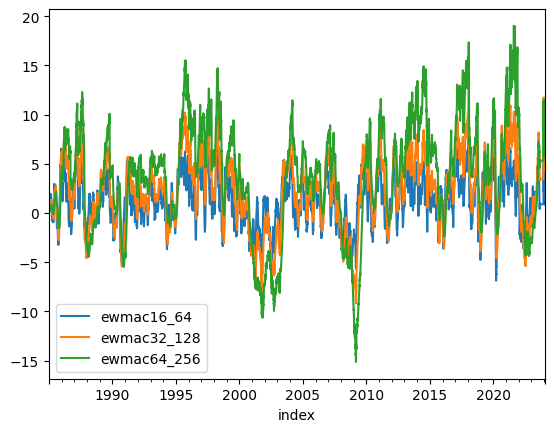

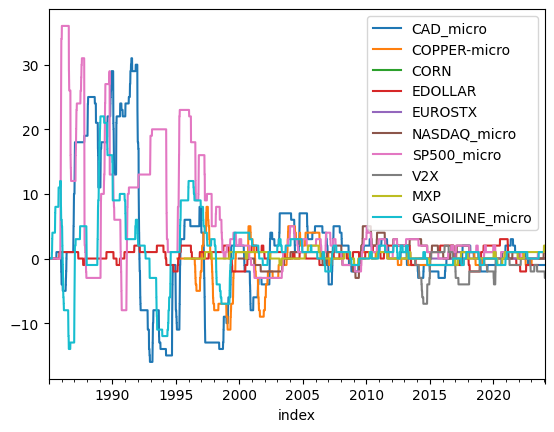

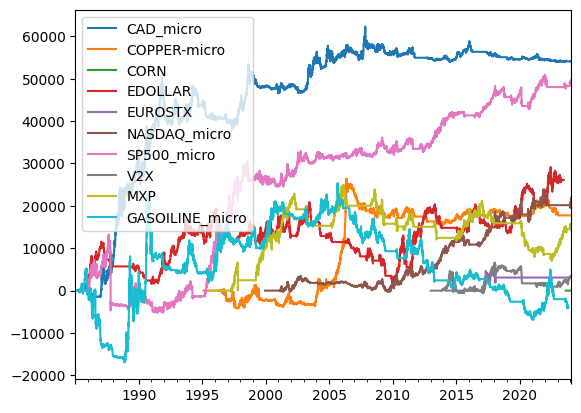

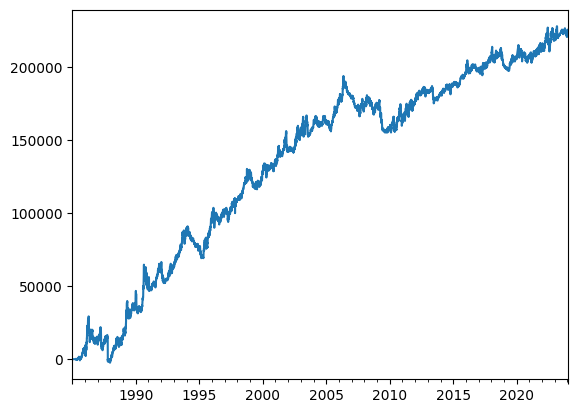

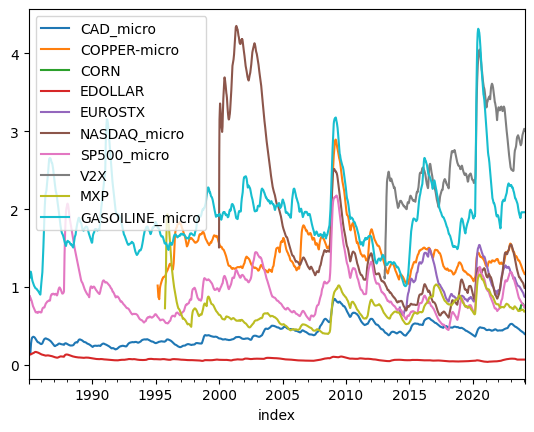

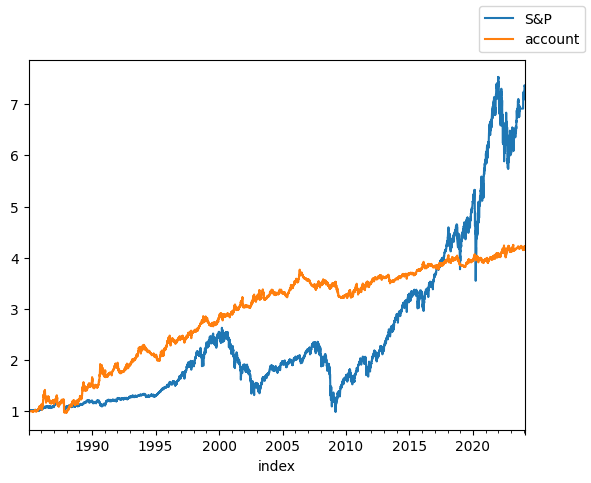

In [48]:
fig, ax = plt.subplots()
for_each('strategy', system,
         system.rules.get_raw_forecast,
         instrument_code='SP500_micro',
        ).plot(ax=ax)

fig, ax = plt.subplots()
for_each('instrument', system,
         system.accounts.get_buffered_position,
        ).plot(ax=ax)


fig, ax = plt.subplots()
for_each('instrument',
         system, system.accounts.pandl_for_instrument,
         funcs=[pd.DataFrame.cumsum],).plot(ax=ax)

fig, ax = plt.subplots()
pf.curve().plot(ax=ax)

fig, ax = plt.subplots()
vols = for_each('instrument', system, system.rawdata.get_daily_percentage_volatility)
vols.ewm(128).mean().plot(ax=ax)


fig, ax = plt.subplots()
account = pf.percent.curve()
sp = system.accounts.get_daily_prices('SP500_micro')
sprets = (1+sp.pct_change()).cumprod()
sprets.rename('S&P').plot(ax=ax)
(1+account/100).rename('account').plot(ax=ax)
fig.legend()
# (1+sp_account/100).plot()
#plt.plot(sp.index, 1+sp_account/100, label='SP Account')
pf.percent.stats()

In [43]:
from sysproduction.data.backtest import dataBacktest
from sysproduction.strategy_code import report_system_classic

bt = dataBacktest().get_most_recent_backtest(strategy_name='example')

#report_system_classic.report_system_classic(data, bt)

2024-02-11 00:17:21 DEBUG root Cache has expired data, fetching from slow path and reloading cache.


<Axes: >

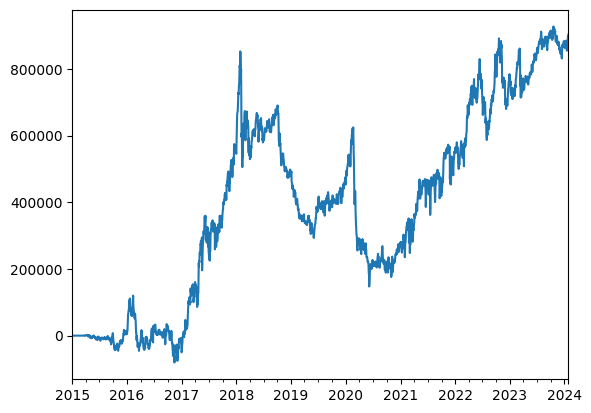

In [44]:
bt.system.accounts.portfolio().curve().plot()

In [39]:
data = for_each('instrument', system, system.accounts.get_buffered_position).diff()
pd.concat((data.SP500_micro[data.SP500_micro.ne(0)].dropna().index.to_series(),
           np.sign(data.SP500_micro[data.SP500_micro.ne(0)].dropna())), axis=1)
           

,index,SP500_micro
index,,
2021-08-13,2021-08-13,1.0
2022-01-25,2022-01-25,-1.0
2023-07-26,2023-07-26,1.0


[[('min', '-2.577'),
  ('max', '2.376'),
  ('median', '0'),
  ('mean', '0.01305'),
  ('std', '0.3415'),
  ('skew', '-0.5818'),
  ('ann_mean', '3.34'),
  ('ann_std', '5.464'),
  ('sharpe', '0.6112'),
  ('sortino', '0.7067'),
  ('avg_drawdown', '-1.405'),
  ('time_in_drawdown', '0.8377'),
  ('calmar', '0.8027'),
  ('avg_return_to_drawdown', '2.378'),
  ('avg_loss', '-0.2707'),
  ('avg_gain', '0.2446'),
  ('gaintolossratio', '0.9037'),
  ('profitfactor', '1.127'),
  ('hitrate', '0.5551'),
  ('t_stat', '1.081'),
  ('p_value', '0.28')],
 ('You can also plot / print:',
  ['rolling_ann_std', 'drawdown', 'curve', 'percent'])]

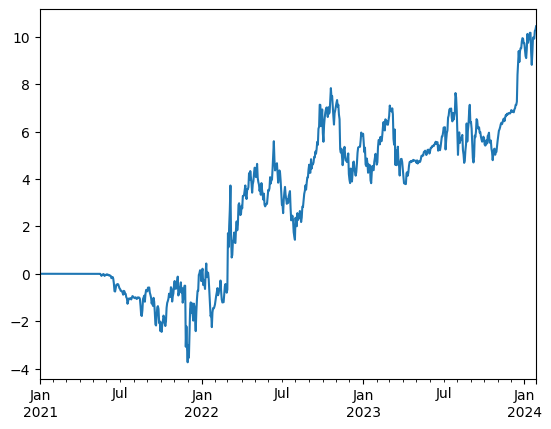

In [41]:
# system.accounts.get_buffered_position('SP500_micro', 'meanreversion').plot()
system.accounts.portfolio().percent.curve().plot()
system.accounts.portfolio().percent.stats()
#system.accounts.get_buffered_position('SP500_micro').plot()

In [201]:
system.rules

{'ewmac2_8': TradingRule; function: <function ewmac at 0x7eff7dd58d30>, data: rawdata.get_daily_prices (args: {}), rawdata.daily_returns_volatility (args: {}) and other_args: Lfast, Lslow,
 'ewmac4_16': TradingRule; function: <function ewmac at 0x7eff7dd58d30>, data: rawdata.get_daily_prices (args: {}), rawdata.daily_returns_volatility (args: {}) and other_args: Lfast, Lslow,
 'ewmac8_32': TradingRule; function: <function ewmac at 0x7eff7dd58d30>, data: rawdata.get_daily_prices (args: {}), rawdata.daily_returns_volatility (args: {}) and other_args: Lfast, Lslow,
 'ewmac16_64': TradingRule; function: <function ewmac at 0x7eff7dd58d30>, data: rawdata.get_daily_prices (args: {}), rawdata.daily_returns_volatility (args: {}) and other_args: Lfast, Lslow,
 'ewmac32_128': TradingRule; function: <function ewmac at 0x7eff7dd58d30>, data: rawdata.get_daily_prices (args: {}), rawdata.daily_returns_volatility (args: {}) and other_args: Lfast, Lslow,
 'ewmac64_256': TradingRule; function: <function

<Axes: xlabel='index'>

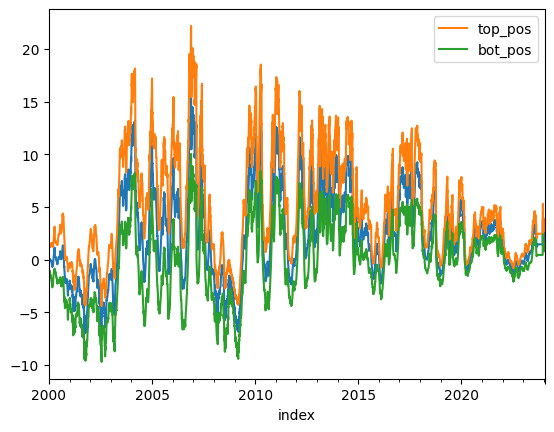

In [808]:

fig,ax = plt.subplots()
ax.xaxis.set_major_locator(matplotlib.dates.YearLocator(base=1))
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y"))


#pf.percent.curve().plot(ax=ax)
buffered_pos = system.accounts.get_actual_buffers_for_position('SP500_micro')

actual_pos = system.accounts.get_actual_position('SP500_micro')
actual_pos.plot(ax=ax)
buffered_pos.plot(ax=ax)
#system.accounts.get_capped_forecast('EDOLLAR', 'ewmac64_256').rename('ewmac64_256').tail(120).plot()
#system.accounts.get_capped_forecast('EDOLLAR', 'ewmac4_16').rename('ewmac4_16').tail(120).plot()


<Axes: xlabel='index'>

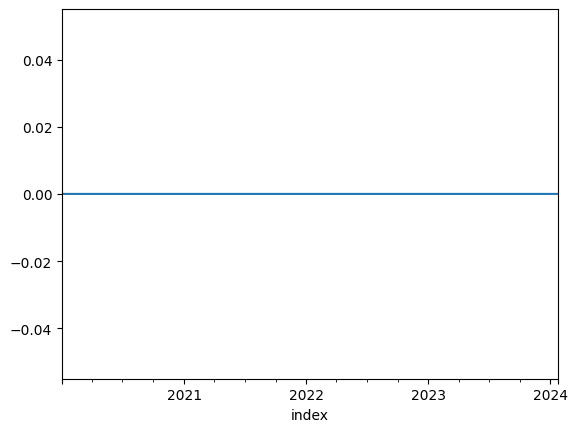

In [621]:
system.accounts.get_buffered_position('V2X').plot()

<Axes: xlabel='index'>

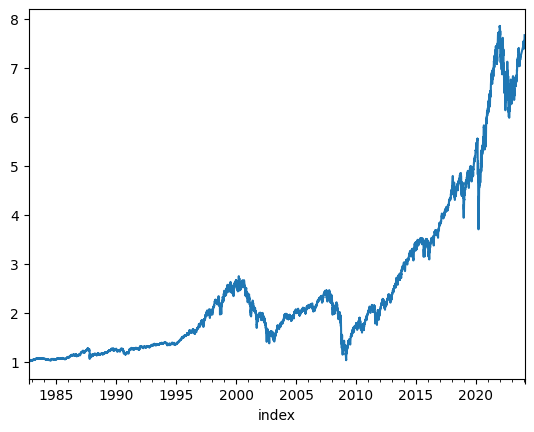

In [26]:
(1+sp.pct_change()).cumprod().plot()

In [244]:
system.accounts.get_daily_returns_volatility('SP500')

index
1985-01-02          NaN
1985-01-03          NaN
1985-01-04          NaN
1985-01-07          NaN
1985-01-08          NaN
                ...    
2024-01-18    29.177680
2024-01-19    31.194764
2024-01-22    30.060925
2024-01-23    29.137743
2024-01-24    28.174886
Freq: B, Name: price, Length: 10191, dtype: float64

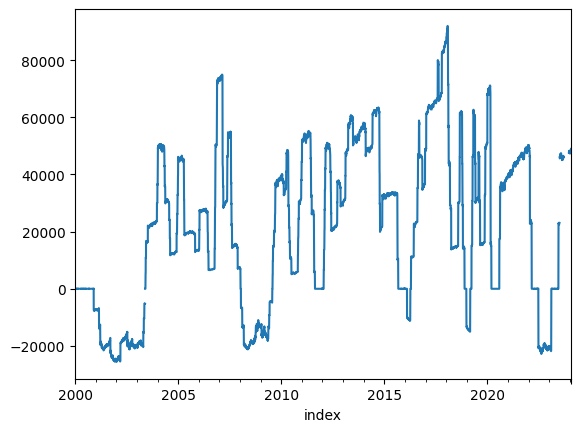

In [809]:

import numpy as np
#system.combForecast.get_monthly_raw_forecast_weights_estimated('SP500_micro')#.diff().ewm(120).std(),
# np.corrcoef(
#     system.accounts.get_daily_returns_volatility('SP500_micro'),
#     system.combForecast.get_monthly_raw_forecast_weights_estimated('SP500_micro')#.diff().ewm(120).std(),
# )
plot = ((system.accounts.get_buffered_position('SP500_micro')
 * 5
 * system.accounts.get_daily_prices('SP500_micro'))
    .plot())


In [308]:
data.get_all_instrument_data_as_df()

,Description,Pointsize,Currency,AssetClass,PerBlock,Percentage,PerTrade,Region
Instrument,,,,,,,,
CORN,Corn,50.0,USD,Ags,2.92,0.0,0,US
EDOLLAR,US STIR Eurodollar,2500.0,USD,Bond,2.11,0.0,0,US
EUROSTX,European equity index EUROSTOXX50,10.0,EUR,Equity,2.00,0.0,0,EMEA
MXP,MEXUSD currency,500000.0,USD,FX,2.47,0.0,0,US
SP500,US equity index S&P500,50.0,USD,Equity,2.05,0.0,0,US
NASDAQ_micro,NASDAQ micro,2.0,USD,Equity,0.57,0.0,0,US
GASOILINE_micro,NYMEX micro Gasoline RBOB Index,4200.0,USD,OilGas,0.85,0.0,0,US
CAD_micro,CADUSD_micro,10000.0,USD,FX,0.85,0.0,0,US
SP500_micro,S&P 500 micro,5.0,USD,Equity,0.57,0.0,0,US


<Axes: xlabel='index'>

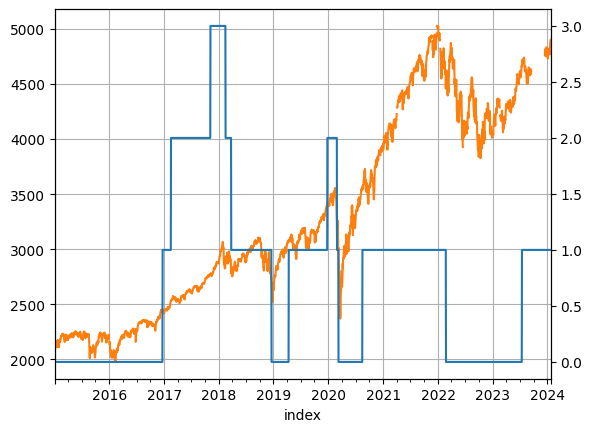

In [737]:
instrument_code = 'SP500_micro'
pv = data.get_all_instrument_data_as_df()['Pointsize'].loc['SP500_micro']
position = system.accounts.get_buffered_position(instrument_code)
price = system.accounts.get_daily_prices(instrument_code)

position.plot(secondary_y=True, grid=True)
price.plot(grid=True)

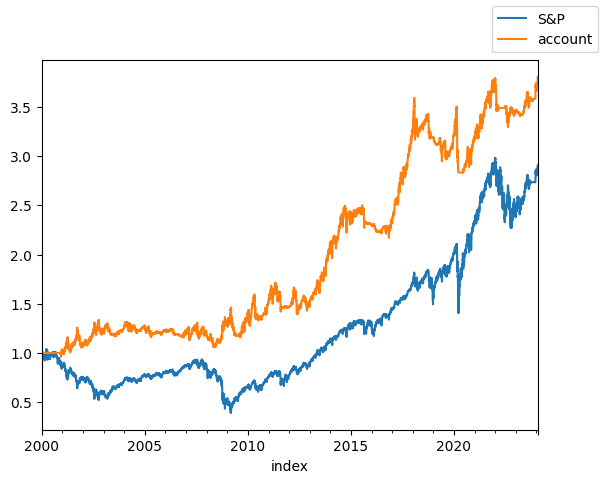

In [857]:
stats, *_ = system.accounts.portfolio().stats()
pd.DataFrame(stats).set_index(0).transpose().rename({1: 'example'}, axis=0)

,min,max,median,mean,std,skew,ann_mean,ann_std,sharpe,sortino,...,time_in_drawdown,calmar,avg_return_to_drawdown,avg_loss,avg_gain,gaintolossratio,profitfactor,hitrate,t_stat,p_value
example,-4309,3365,0,13.41,452.1,-1.027,3434,7234,0.4747,0.5179,...,0.9189,0.1506,0.6571,-313.3,289.2,0.9229,1.103,0.5443,2.351,0.01877


In [188]:
df = pd.concat((adjusted_prices.read(c).data.squeeze().rename(c) for c in adjusted_prices.list_symbols()), axis=1)

In [38]:
pip install --upgrade nuitka 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 7.4 MB/s eta 0:00:00m eta 0:00:010:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached ordered_set-4.1.0-py3-none-any.whl (7.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 7.4 MB/s eta 0:00:00m eta 0:00:010:00:01
  Created wheel for nuitka: filename=Nuitka-1.9.7-cp38-cp38-linux_x86_64.whl size=3203624 sha256=1066d3739fc9b62571f68bd4db3d273f9f1e104343e93d976f92a2da58319634
  Stored in directory: /home/rory/.cache/pip/wheels/85/8c/81/03b9e6c6b3d702feb13bd160dec5d6600937169ef045c559c3
Successfully built nuitka

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


,price
index,
2024-01-22 20:00:00,NaN
2024-01-22 21:00:00,NaN
2024-01-22 23:00:00,NaN
2024-01-22 23:00:01,4880.75
2024-01-22 23:00:02,4880.75


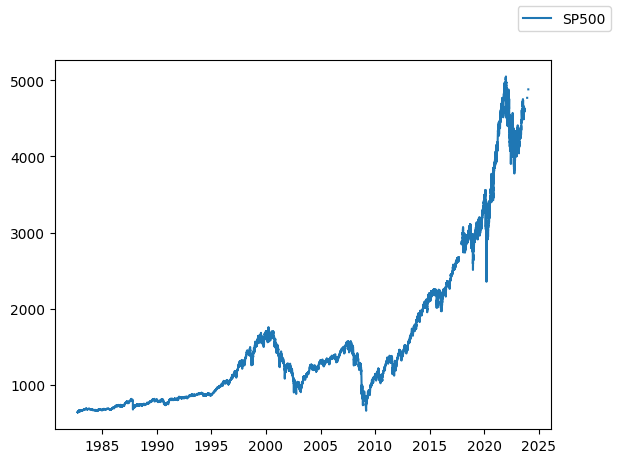

In [264]:
fig, ax = plt.subplots()
#pf.percent.curve().rename('example').plot(ax=ax)
pxs = adjusted_prices.read('SP500').data
ax.plot(pxs.index, pxs, label='SP500')
fig.legend()
pxs.tail()




In [152]:
from sysproduction.data import backtest

In [153]:
bt = backtest.dataBacktest()

In [39]:
bt = bt.get_most_recent_backtest('example')

2024-01-22 20:14:31 DEBUG base_system {'stage': 'config'} Adding config defaults


In [51]:
adjusted_prices.read('EDOLLAR').data.tail(50)

,price
index,
2023-04-14 21:00:00,96.76
2023-04-14 23:00:00,96.76
2023-04-17 23:00:00,96.74
2023-04-18 23:00:00,96.74
2023-04-19 23:00:00,96.74
2023-04-20 23:00:00,96.74
2023-04-21 23:00:00,96.74
2023-04-24 23:00:00,96.74
2023-04-25 23:00:00,96.74


In [44]:
system.portfolio.

TypeError: 'Portfolios' object is not callable